In [ ]:
!pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.spatial import distance_matrix

# 1. Load Data from CSV
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 2. Create Graph Data
def create_graph(df, distance_threshold):
    # Node features: Latitude, Longitude, and Population
    node_features = torch.tensor(df[['Latitude', 'Longitude', 'population']].values, dtype=torch.float)

    # Create edge index based on proximity (using a distance matrix)
    coords = df[['Latitude', 'Longitude']].values
    dist_matrix = distance_matrix(coords, coords)

    # Define edges where the distance between nodes is less than the threshold
    edge_index = np.array(np.where(dist_matrix < distance_threshold))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Create the graph data structure
    graph_data = Data(x=node_features, edge_index=edge_index)
    return graph_data

# 3. GNN Model Definition
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First GCN Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second GCN Layer
        x = self.conv2(x, edge_index)

        return x

# 4. Train and Test Split (we assume you have separate CSVs for train and test)
train_data = load_data('/content/updated_data_train.csv')
test_data = load_data('/content/updated_data.csv')

# Define a distance threshold for edge creation (e.g., 0.1 degree distance)
distance_threshold = 0.1

# Create graph structures
train_graph = create_graph(train_data, distance_threshold)
test_graph = create_graph(test_data, distance_threshold)

# 5. Training the GNN Model
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Using population as the target
    target = data.x[:, 2]  # Population field is the target

    # Loss function (MSE for regression)
    loss = criterion(out[:, 2], target)
    loss.backward()
    optimizer.step()
    return loss.item()

# 6. Evaluation Function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        target = data.x[:, 2]  # Population field
        pred = out[:, 2]  # Predicted population
        mse = mean_squared_error(target.numpy(), pred.numpy())
        return mse

# Hyperparameters
input_features = 3  # Latitude, Longitude, Population
hidden_features = 16
output_features = 3  # Output the same features

# Initialize model, optimizer, and loss function
model = GNNModel(in_channels=input_features, hidden_channels=hidden_features, out_channels=output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train(model, train_graph, optimizer, criterion)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Evaluation on the test dataset
mse = evaluate(model, test_graph)
print(f'Test Mean Squared Error: {mse}')


FileNotFoundError: [Errno 2] No such file or directory: '/content/updated_data_train.csv'

In [ ]:
!pip install torch torch-geometric scikit-learn matplotlib


<ipython-input-10-1003b989f8b8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(train_coords[['Latitude', 'Longitude', 'population']])


Epoch 0, Loss: 0.23054306209087372
Epoch 10, Loss: 0.017130674794316292
Epoch 20, Loss: 0.010633072815835476
Epoch 30, Loss: 0.007854422554373741
Epoch 40, Loss: 0.006176432594656944
Epoch 50, Loss: 0.0057793548330664635
Epoch 60, Loss: 0.00540741253644228
Epoch 70, Loss: 0.005104794166982174
Epoch 80, Loss: 0.004816024098545313
Epoch 90, Loss: 0.004537560045719147
Epoch 100, Loss: 0.004250102210789919
Epoch 110, Loss: 0.003940336871892214
Epoch 120, Loss: 0.0036006292793899775
Epoch 130, Loss: 0.0032029622234404087
Epoch 140, Loss: 0.0028043542988598347
Epoch 150, Loss: 0.0024122977629303932
Epoch 160, Loss: 0.002076974604278803
Epoch 170, Loss: 0.0017717460868880153
Epoch 180, Loss: 0.0015826105372980237
Epoch 190, Loss: 0.0013802509056404233
Epoch 200, Loss: 0.0012371520278975368
Epoch 210, Loss: 0.0011610606452450156
Epoch 220, Loss: 0.0010416045552119613
Epoch 230, Loss: 0.000946024083532393
Epoch 240, Loss: 0.0008843958494253457
Epoch 250, Loss: 0.0013886980013921857
Epoch 260, L

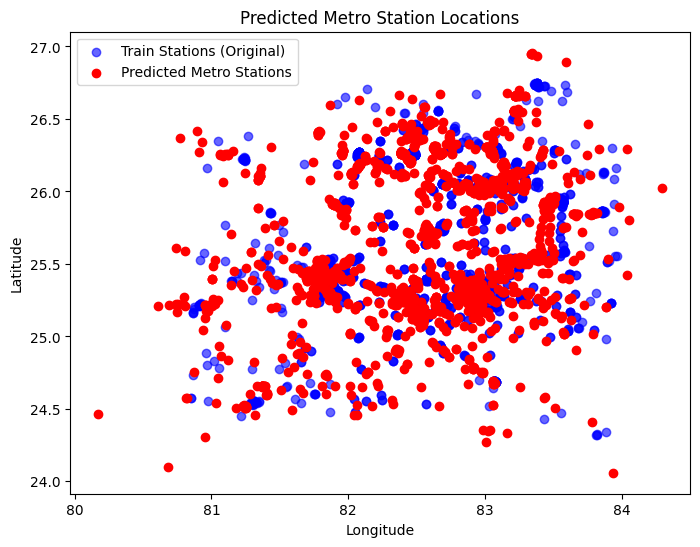

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(train_coords[['Latitude', 'Longitude', 'population']])

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges between nodes based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        G.add_edge(i, neighbors[j])

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
for edge in G.edges():
    edge_index.append([edge[0], edge[1]])

# Convert node features and edge index to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Define the GCN model
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Input: 3 features (Lat, Long, Population)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 2)  # Output: 2 features (Predicted Lat, Long)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = data.x[:, :2]  # Target is Latitude and Longitude (first two features)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-11-6839a41ed78f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.14304670691490173
Epoch 10, Loss: 0.028936414048075676
Epoch 20, Loss: 0.017867930233478546
Epoch 30, Loss: 0.015297972597181797
Epoch 40, Loss: 0.012968407943844795
Epoch 50, Loss: 0.011607355438172817
Epoch 60, Loss: 0.010314499959349632
Epoch 70, Loss: 0.008966775611042976
Epoch 80, Loss: 0.007596713490784168
Epoch 90, Loss: 0.006143293343484402
Epoch 100, Loss: 0.004998046439141035
Epoch 110, Loss: 0.003851665649563074
Epoch 120, Loss: 0.0032120554242283106
Epoch 130, Loss: 0.002816417021676898
Epoch 140, Loss: 0.002585679292678833
Epoch 150, Loss: 0.002418963238596916
Epoch 160, Loss: 0.0022945289965718985
Epoch 170, Loss: 0.0021450724452733994
Epoch 180, Loss: 0.0023884489201009274
Epoch 190, Loss: 0.0020085510332137346
Epoch 200, Loss: 0.002007074188441038
Epoch 210, Loss: 0.0019161974778398871
Epoch 220, Loss: 0.0018652508733794093
Epoch 230, Loss: 0.0019372847164049745
Epoch 240, Loss: 0.0017940289108082652
Epoch 250, Loss: 0.0016966300318017602
Epoch 260, Los

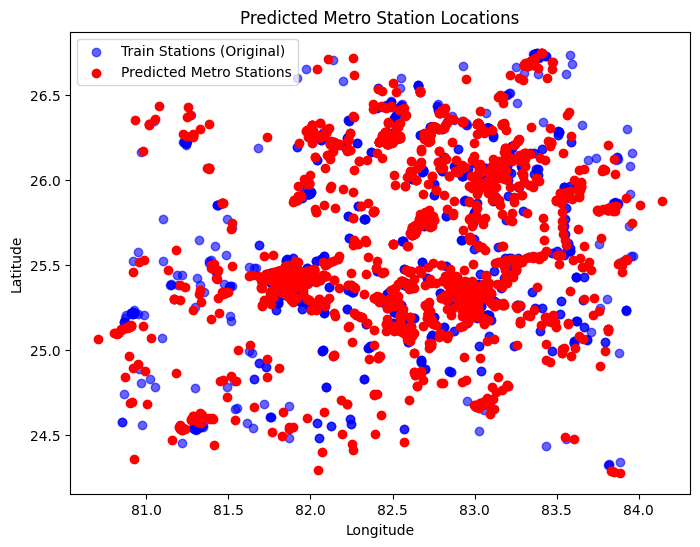

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Input: 3 features (Lat, Long, Population)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 2)  # Output: 2 features (Predicted Lat, Long)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = torch.relu(x)
        x = self.conv3(x, edge_index, edge_weight=edge_weight)
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = data.x[:, :2]  # Target is Latitude and Longitude (first two features)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-12-803459f5c7fc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931613683700562
Epoch 10, Loss: 0.6926825642585754
Epoch 20, Loss: 0.6920063495635986
Epoch 30, Loss: 0.6916271448135376
Epoch 40, Loss: 0.6909828186035156
Epoch 50, Loss: 0.6902081966400146
Epoch 60, Loss: 0.6896786093711853
Epoch 70, Loss: 0.6902605891227722
Epoch 80, Loss: 0.6895924806594849
Epoch 90, Loss: 0.6891879439353943
Epoch 100, Loss: 0.6891366243362427
Epoch 110, Loss: 0.6890700459480286
Epoch 120, Loss: 0.6895207762718201
Epoch 130, Loss: 0.6880936026573181
Epoch 140, Loss: 0.6880634427070618
Epoch 150, Loss: 0.6874082684516907
Epoch 160, Loss: 0.6868355870246887
Epoch 170, Loss: 0.6868452429771423
Epoch 180, Loss: 0.6875086426734924
Epoch 190, Loss: 0.6860798001289368
Epoch 200, Loss: 0.6860052347183228
Epoch 210, Loss: 0.6858320832252502
Epoch 220, Loss: 0.685073971748352
Epoch 230, Loss: 0.6834957003593445
Epoch 240, Loss: 0.694061815738678
Epoch 250, Loss: 0.6913039684295654
Epoch 260, Loss: 0.6905943751335144
Epoch 270, Loss: 0.689828097820282
Epoch 

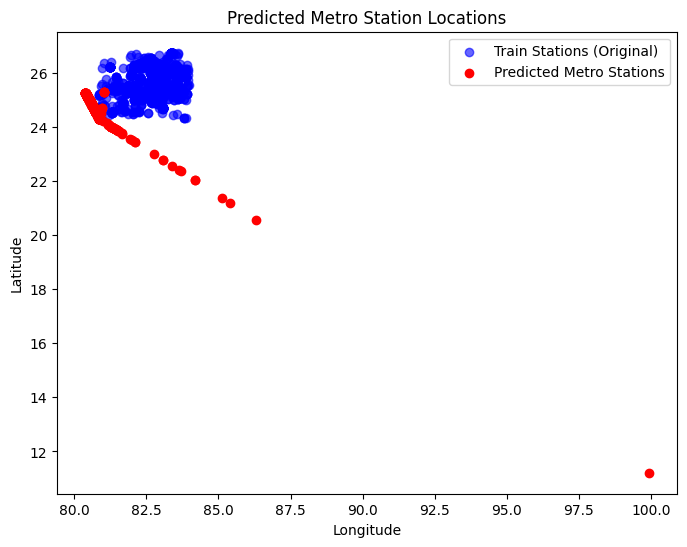

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 2)  # Output: 2 classes (for classification)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = self.conv10(x, edge_index, edge_weight=edge_weight)  # No activation here
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target classes for cross-entropy (binned latitude/longitude)
# Assuming we have class labels for training; adjust this as needed
num_classes = 2  # Placeholder: Set the actual number of classes based on your use case
target = torch.randint(0, num_classes, (data.num_nodes,))  # Random labels as placeholder

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # Cross-entropy loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-13-3fb1232d503d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.31725654006004333
Epoch 10, Loss: 0.04824961721897125
Epoch 20, Loss: 0.03830454871058464
Epoch 30, Loss: 0.02943003550171852
Epoch 40, Loss: 0.022331351414322853
Epoch 50, Loss: 0.01408630982041359
Epoch 60, Loss: 0.01070421189069748
Epoch 70, Loss: 0.011779235675930977
Epoch 80, Loss: 0.00723156938329339
Epoch 90, Loss: 0.006353451870381832
Epoch 100, Loss: 0.005531073547899723
Epoch 110, Loss: 0.004668414127081633
Epoch 120, Loss: 0.003817127551883459
Epoch 130, Loss: 0.00607473636046052
Epoch 140, Loss: 0.005943414755165577
Epoch 150, Loss: 0.004221430514007807
Epoch 160, Loss: 0.003303294302895665
Epoch 170, Loss: 0.0026895662304013968
Epoch 180, Loss: 0.0023837590124458075
Epoch 190, Loss: 0.0021506943739950657
Epoch 200, Loss: 0.0019667530432343483
Epoch 210, Loss: 0.0018357093213126063
Epoch 220, Loss: 0.0017291544936597347
Epoch 230, Loss: 0.0017047491855919361
Epoch 240, Loss: 0.0015556307043880224
Epoch 250, Loss: 0.001320281415246427
Epoch 260, Loss: 0.0012

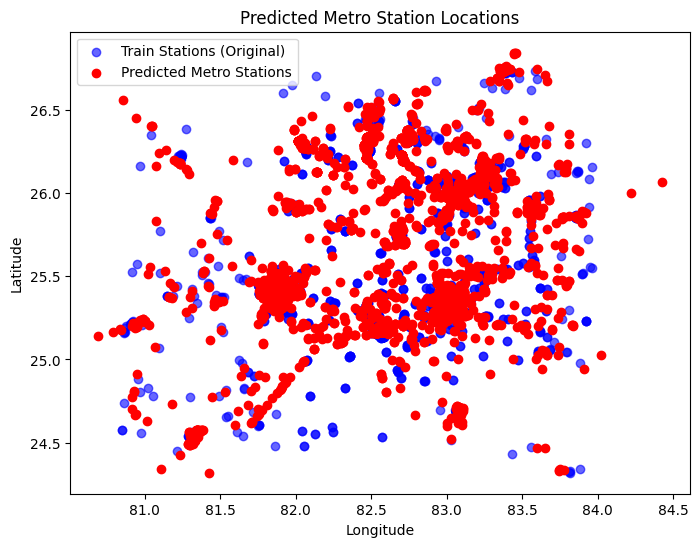

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for regression
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 2)  # Output layer for latitude and longitude (2 continuous values)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = self.conv10(x, edge_index, edge_weight=edge_weight)  # Linear output for regression
        return x

# Initialize the model, MSE loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()  # Use MSE loss for continuous target prediction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target coordinates (Latitude and Longitude scaled) as the ground truth for regression
target = torch.tensor(train_coords[['Latitude', 'Longitude']].values, dtype=torch.float)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # MSE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-14-6763777f67f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931452751159668
Epoch 10, Loss: 0.6927231550216675
Epoch 20, Loss: 0.6921813488006592
Epoch 30, Loss: 0.6915861368179321
Epoch 40, Loss: 0.6916754245758057
Epoch 50, Loss: 0.6914126873016357
Epoch 60, Loss: 0.6905869245529175
Epoch 70, Loss: 0.6903109550476074
Epoch 80, Loss: 0.6899397373199463
Epoch 90, Loss: 0.6890845894813538
Epoch 100, Loss: 0.6886997818946838
Epoch 110, Loss: 0.6882324814796448
Epoch 120, Loss: 0.6906383633613586
Epoch 130, Loss: 0.6902036070823669
Epoch 140, Loss: 0.6893314123153687
Epoch 150, Loss: 0.6892095804214478
Epoch 160, Loss: 0.6880289912223816
Epoch 170, Loss: 0.6880493760108948
Epoch 180, Loss: 0.688401460647583
Epoch 190, Loss: 0.6880517601966858
Epoch 200, Loss: 0.6872329711914062
Epoch 210, Loss: 0.6855007410049438
Epoch 220, Loss: 0.6857191920280457
Epoch 230, Loss: 0.6877817511558533
Epoch 240, Loss: 0.686774730682373
Epoch 250, Loss: 0.6869762539863586
Epoch 260, Loss: 0.6855842471122742
Epoch 270, Loss: 0.6853115558624268
Epoch

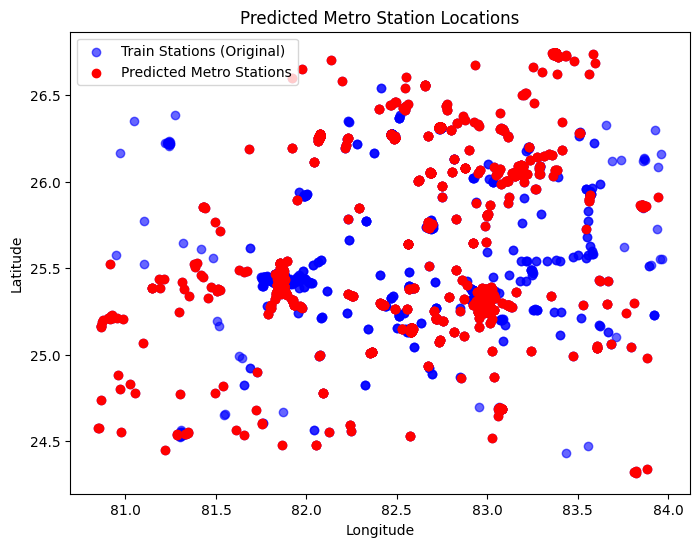

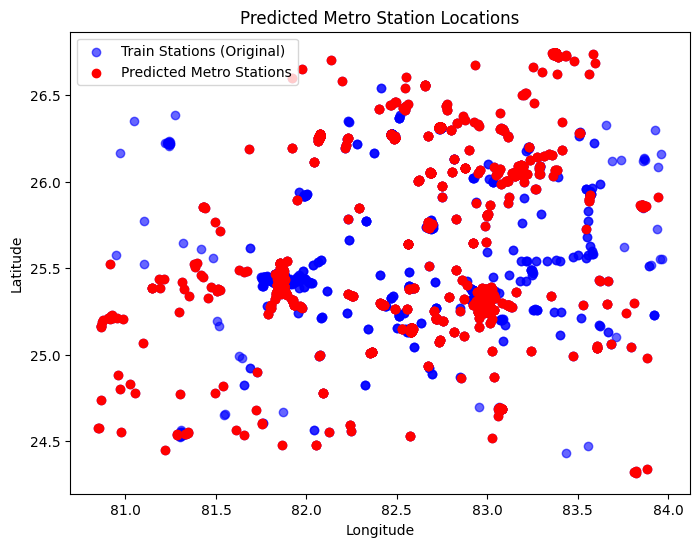

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions and convert them to binary classification
# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-15-19f8c95feb45>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931648850440979, Accuracy: 49.68%
Epoch 10, Loss: 0.6925976276397705, Accuracy: 51.07%
Epoch 20, Loss: 0.6922726631164551, Accuracy: 51.14%
Epoch 30, Loss: 0.691603422164917, Accuracy: 51.59%
Epoch 40, Loss: 0.6898005604743958, Accuracy: 53.39%
Epoch 50, Loss: 0.6889727711677551, Accuracy: 53.89%
Epoch 60, Loss: 0.6905975341796875, Accuracy: 52.81%
Epoch 70, Loss: 0.688266932964325, Accuracy: 54.85%
Epoch 80, Loss: 0.686729907989502, Accuracy: 54.27%
Epoch 90, Loss: 0.6845810413360596, Accuracy: 54.99%
Epoch 100, Loss: 0.6844465136528015, Accuracy: 55.14%
Epoch 110, Loss: 0.6824061274528503, Accuracy: 54.94%
Epoch 120, Loss: 0.6810418963432312, Accuracy: 56.16%
Epoch 130, Loss: 0.6812194585800171, Accuracy: 55.76%
Epoch 140, Loss: 0.6812673211097717, Accuracy: 55.35%
Epoch 150, Loss: 0.6786457896232605, Accuracy: 56.21%
Epoch 160, Loss: 0.6794822216033936, Accuracy: 56.81%
Epoch 170, Loss: 0.6772337555885315, Accuracy: 56.95%
Epoch 180, Loss: 0.6756688356399536, Accur

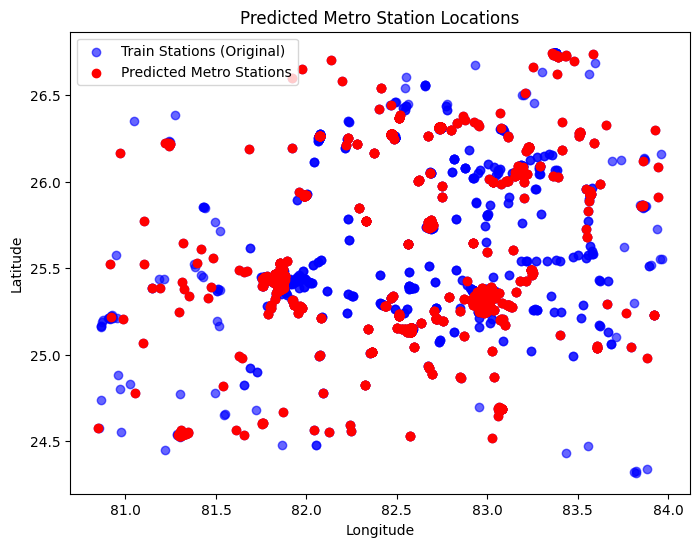

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model with accuracy tracking
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target).sum().item()
        accuracy = correct / target.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                             Name  \
0                  bar                                       mohini bar   
1                  bar                                      The Gem Bar   
2                  bar                                OMG Bar & Kitchen   
3                  bar                                         My Love    
4                  bar                                        Sam's bar   
...                ...                                              ...   
1274  place_of_worship  Dargah Hazrat Baba Rangeele Shah Chisthi Nizami   
1275  place_of_worship                         Sindhi Sat Sangat Darbar   
1276       public_bath                                      Deluxe Bath   
1277       public_bath                                      Deluxe Bath   
1278   public_building                                              NIC   

       Latitude  Longitude                               road  \
0     28.633277  77.223876        

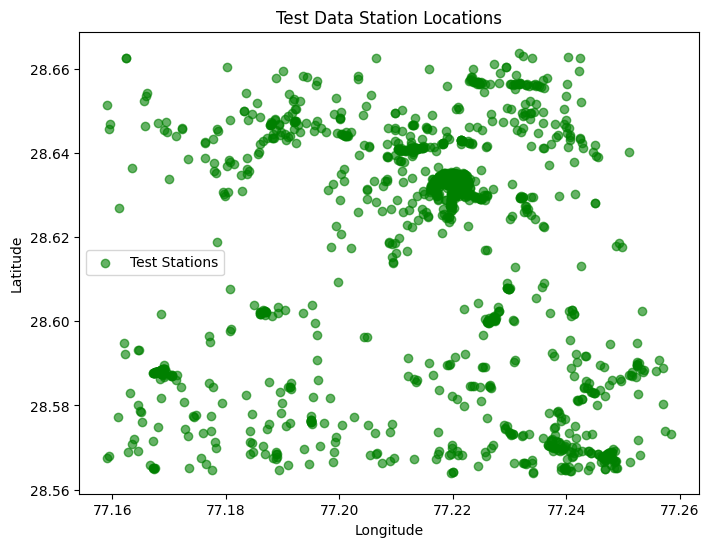

In [ ]:
# Load the test data
test_data = pd.read_csv('updated_data.csv')

print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                       Name   Latitude  \
0                  bar                                      jyoti  26.070360   
1                  bar                                      Lassi  25.429981   
2                  bar                                 Beer “Bar”  25.308876   
3                  bar                                   Beer Bar  25.309253   
4                  bar                                    Sol Bar  25.338722   
...                ...                                        ...        ...   
4172  place_of_worship                               Shiva Mandir  25.308244   
4173  place_of_worship                             Sita Mata Dham  25.771454   
4174  place_of_worship  Sri Mahavir Ji Mandir Temple Bari Bagahin  25.245697   
4175  place_of_worship                                Shiv Temple  25.638992   
4176  place_of_worship                         Chaura Mata Mandir  25.638231   

      Longitude                       r

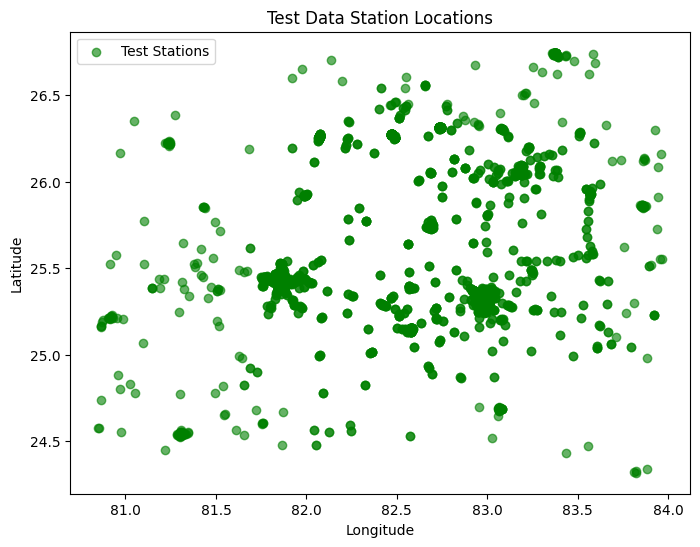

In [ ]:
# Load the test data
test_data = pd.read_csv('updated_data_train.csv')

print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Output layer for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Remove single-dimensional entries from the shape

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target labels (binary: 1 for metro station, 0 for non-station)
# Example: create random binary labels as a placeholder. Replace with actual labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Binarize probabilities to get labels (0 or 1)

# Plot the original train data and predicted stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
predicted_positions = train_coords[['Longitude', 'Latitude']].iloc[predicted_labels == 1]
plt.scatter(predicted_positions['Longitude'], predicted_positions['Latitude'], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:
import random

# After predicting all the stations:
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Step 1: Randomly select 100 stations from the predicted positions
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 2: Plot only the selected 100 stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, and `train_data` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_positions = random.sample(predicted_positions.tolist(), sample_size)
        sampled_positions = np.array(sampled_positions)
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size

    # Accuracy Score Calculation (Assuming `true_positions` is defined for comparison)
    # Here, `true_positions` should contain actual Lat and Long values to compare.
    accuracy_score = mean_squared_error(true_positions[:sample_size], sampled_positions) if 'true_positions' in locals() else 'N/A'

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, `train_data`, and `true_positions` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_indices = random.sample(range(predicted_positions.shape[0]), sample_size)
        sampled_positions = predicted_positions[sampled_indices]
        sampled_true_positions = true_positions[sampled_indices]  # Select corresponding true positions
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size
        sampled_true_positions = true_positions  # Use all true positions

    # Calculate accuracy (MSE)
    accuracy_score = mean_squared_error(sampled_true_positions, sampled_positions)

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


In [ ]:
import heapq
import math

# Heuristic function: Euclidean distance between two nodes
def heuristic(node1, node2):
    return math.sqrt((node1[0] - node2[0]) ** 2 + (node1[1] - node2[1]) ** 2)

# A* algorithm to find the path between two nodes
def astar(start, goal, graph):
    open_list = []
    heapq.heappush(open_list, (0, start))

    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0

    f_score = {node: float('inf') for node in graph}
    f_score[start] = heuristic(start, goal)

    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path

        for neighbor in graph[current]:
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return []  # Return an empty path if no path is found

# Build a graph for A* pathfinding from the selected 100 stations
def build_graph(stations):
    graph = {}
    for i, station1 in enumerate(stations):
        graph[tuple(station1)] = []
        for j, station2 in enumerate(stations):
            if i != j:
                graph[tuple(station1)].append(tuple(station2))
    return graph

# After random selection of 100 stations:
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 1: Build the graph from the selected 100 stations
graph = build_graph(sampled_positions)

# Step 2: Connect all stations using A* algorithm and store the paths
metro_lines = []
for i in range(len(sampled_positions) - 1):
    start_station = tuple(sampled_positions[i])
    end_station = tuple(sampled_positions[i + 1])
    path = astar(start_station, end_station, graph)
    metro_lines.append(path)

# Step 3: Plot the metro stations and the A* metro lines
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')

# Plotting metro lines
for path in metro_lines:
    if path:  # Ensure the path is valid
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], color='green',)

plt.title('Predicted Metro Station Locations and Metro Line (A*)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
